# Обучение осуществлял в Goggle Collab

# 1. Загрузка данных

In [1]:
from pathlib import Path
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install googledrivedownloader

from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1-HUNDjcmSqdtMCvEkVlI0q43qlkcXBdK',
                                    dest_path='./internship_data.tar.gz')

In [3]:
tar = tarfile.open("internship_data.tar.gz")
tar.extractall()
tar.close()

In [4]:
base_dir = Path('internship_data')
male_dir = base_dir / 'male'
female_dir = base_dir / 'female'

male_count = len(list(male_dir.glob("*.jpg")))
female_count = len(list(female_dir.glob("*.jpg")))

total = female_count + male_count

print('Male images:', male_count)
print('Female images:', female_count)
print("--")
print("Total images:", total)

Male images: 50001
Female images: 50001
--
Total images: 100002


# 2. Подготовка данных к подаче в модель

In [5]:
filenames_male = list(map(lambda x: str(male_dir / x.name), male_dir.glob('*.jpg')))
filenames_female = list(map(lambda x: str(female_dir / x.name), female_dir.glob('*.jpg')))

In [6]:
male_df = pd.DataFrame({'file_name': filenames_male})
male_df['label'] = 'male'

female_df = pd.DataFrame({'file_name': filenames_female})
female_df['label'] = 'female'

df = pd.concat([female_df, male_df]).reset_index(drop=True)
df # df всех изображений

,file_name,label
0,internship_data/female/177583.jpg,female
1,internship_data/female/200589.jpg,female
2,internship_data/female/009185.jpg,female
3,internship_data/female/192234.jpg,female
4,internship_data/female/185544.jpg,female
...,...,...
99997,internship_data/male/032776.jpg,male
99998,internship_data/male/091949.jpg,male
99999,internship_data/male/122349.jpg,male
100000,internship_data/male/175128.jpg,male


### 90% в train
Andrew Ng советует делать train больше при больших датасэтах

In [ ]:
df_train_m = male_df.sample(frac=0.9, random_state=123) # тренировочные данные для мужчин

df_train_f = female_df.sample(frac=0.9, random_state=123) # тренировочные данные для женщин

df_train = pd.concat([df_train_m, df_train_f]).sample(frac=1)
df_train # df с тренировочными данными

,file_name,label
46852,internship_data/female/064110.jpg,female
11147,internship_data/female/183892.jpg,female
10896,internship_data/male/124928.jpg,male
3293,internship_data/male/040366.jpg,male
34379,internship_data/female/182060.jpg,female
...,...,...
34754,internship_data/female/183168.jpg,female
14623,internship_data/male/034333.jpg,male
31242,internship_data/female/042783.jpg,female
2806,internship_data/female/028708.jpg,female


In [ ]:
df_valid = df[~df.set_index('file_name').index.isin(df_train.set_index('file_name').index)].sample(frac=1)
df_valid # df с валидационными данными

,file_name,label
11395,internship_data/female/156346.jpg,female
48681,internship_data/male/141188.jpg,male
15472,internship_data/female/199723.jpg,female
38496,internship_data/female/200988.jpg,female
33701,internship_data/male/027392.jpg,male
...,...,...
8835,internship_data/female/156283.jpg,female
3178,internship_data/female/067811.jpg,female
32309,internship_data/female/032810.jpg,female
41771,internship_data/male/113351.jpg,male


### Откроем случайную картинку

(208, 145, 3)


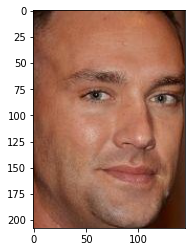

In [ ]:
row = df_train_m.iloc[np.random.randint(len(df_train_m))]
img = plt.imread(str(row["file_name"]))
plt.imshow(img);
print(img.shape)
# Все картинки разные по размеру

# 3. Загрузка модели

In [ ]:
%tensorflow_version 1.x # Ставим нужную версию TF
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
!pip install livelossplot
from livelossplot.inputs.tf_keras import PlotLossesCallback

TensorFlow 1.x selected.


### Попробуем Transfer learning
Грузим модель которая обучалась на похожем дадасете

In [ ]:
! pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-ha1y6pmf
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-ha1y6pmf
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=15c5489cfd11ec2d6107a12c63b69d31defa111f16efc06f6a48a33c824fd2b1
  Stored in directory: /tmp/pip-ephem-wheel-cache-oo9ko97_/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [ ]:
! pip install keras_vggface
! pip install keras_applications

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO'
output = 'resnet50face.h5'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO
To: /content/resnet50face.h5
166MB [00:02, 55.5MB/s]


'resnet50face.h5'

In [ ]:
from tensorflow.keras.models import load_model
from keras_vggface import utils
vggface_model = load_model("resnet50face.h5")
vggface_model.summary() 

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__

In [ ]:
def preprocess_input_facenet(image): # нужна для предобработки изображений
    """
    :param image: тензор размера (1, H, W, 3)
    :return: картинка, с примененным preprocess_input(..., version=2) из keras_vggface 
    """

    preprocessed = utils.preprocess_input(image, version=2)

    return preprocessed


image_gen = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)

In [ ]:
BATCH_SIZE = 256 
IMAGE_SIZE  = 224 # требование модели

train_data_gen = image_gen.flow_from_dataframe(
    dataframe=df_train,
    directory=None,
    x_col='file_name',
    y_col='label',
    weight_col=None,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    classes=None,
    class_mode= "binary",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
    validate_filenames=True)

val_data_gen = image_gen.flow_from_dataframe(
    dataframe=df_valid,
    directory=None,
    x_col='file_name',
    y_col='label',
    weight_col=None,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    classes=None,
    class_mode= "binary",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
    validate_filenames=True)

Found 90002 validated image filenames belonging to 2 classes.
Found 10000 validated image filenames belonging to 2 classes.


# 4. Первый этап обучения

In [ ]:
# отрежем от vggface_model последний слой классификатора 
# теперь base_model предсказывает 2048-мерный вектор признаков.

base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

#### В процессе обучения буду все сохранять ну гугл диск

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
path = Path("/content/drive/My Drive/NtechLab/Model")
path.mkdir(exist_ok=True, parents=True)
assert path.exists()
cpt_filename = "checkpoint_best.h5"
cpt_path =str(path / cpt_filename)
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

Mounted at /content/drive/


In [ ]:
model = tf.keras.Sequential([
    base_model, 
    tf.keras.layers.Dense(1, activation='sigmoid')
     ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

model.summary()
# 2 049 параметров

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 2048)              23561152  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,563,201
Trainable params: 2,049
Non-trainable params: 23,561,152
_________________________________________________________________


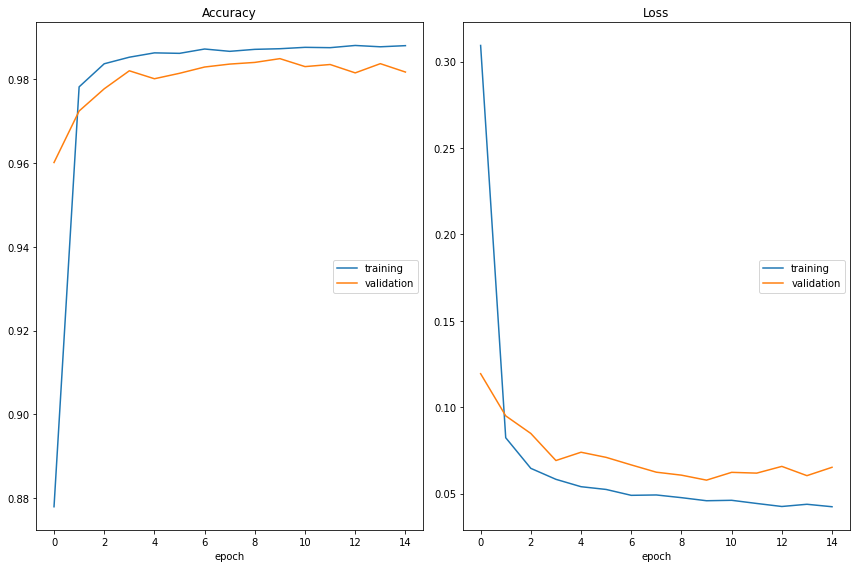

Accuracy
	training         	 (min:    0.878, max:    0.988, cur:    0.988)
	validation       	 (min:    0.960, max:    0.985, cur:    0.982)
Loss
	training         	 (min:    0.042, max:    0.309, cur:    0.042)
	validation       	 (min:    0.058, max:    0.119, cur:    0.065)

Epoch 00015: val_acc did not improve from 0.98490
391/391 [==============================] - 663s 2s/step - loss: 0.0424 - acc: 0.9880 - val_loss: 0.0652 - val_acc: 0.9817


In [ ]:
EPOCHS=15
STEPS_PER_EPOCH = np.round(len(df)/BATCH_SIZE)

history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback(), checkpoint]) 

# 5. Второй этап обучения

### Посмотрим, можно ли улучшить результаты, через fine tuning

Проверяем сохранилась ли модель с прошлого этапа

In [ ]:
model_loading_check = load_model(cpt_path)
loss, acc = model_loading_check.evaluate(val_data_gen)
loss, acc

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
40/40 [==============================] - 27s 685ms/step - loss: 0.0594 - acc: 0.9849


(0.05941017628647387, 0.9849)

In [ ]:
# эту модель будем тюнить
base_model_tunning = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model_tunning.trainable = True
base_model_tunning.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

In [ ]:
layer_names = [layer.name for layer in base_model_tunning.layers]
layer_idx = layer_names.index('conv5_3_1x1_increase') # Откроем все слои, начиния с последнего сверточного
for layer in base_model_tunning.layers[:layer_idx]:
    layer.trainable = False

In [ ]:
base_model_tunning.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

In [ ]:
drive.mount('/content/drive/')
path_first_tune = Path("/content/drive/My Drive/NtechLab/Model_first_tune")
path_first_tune.mkdir(exist_ok=True, parents=True)
assert path_first_tune.exists()
cpt_filename_fist_tune = "checkpoint_first_tune_best.h5"
cpt_path_first_tune =str(path_first_tune / cpt_filename_fist_tune)
checkpoint_first_tune = tf.keras.callbacks.ModelCheckpoint(cpt_path_first_tune, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
model_first_tune = tf.keras.Sequential([
    base_model_tunning, 
    tf.keras.layers.Dense(1, activation='sigmoid')
     ])

model_first_tune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # уменьшил learning rate
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

model_first_tune.summary()

# 1 054 721 параметров

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Model)              (None, 2048)              23561152  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,563,201
Trainable params: 1,054,721
Non-trainable params: 22,508,480
_________________________________________________________________


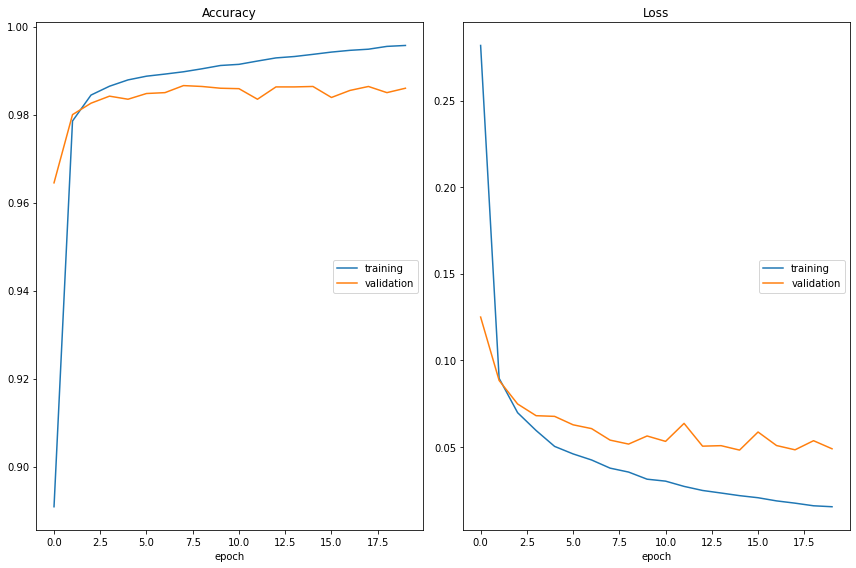

Accuracy
	training         	 (min:    0.891, max:    0.996, cur:    0.996)
	validation       	 (min:    0.965, max:    0.987, cur:    0.986)
Loss
	training         	 (min:    0.015, max:    0.282, cur:    0.015)
	validation       	 (min:    0.048, max:    0.125, cur:    0.049)

Epoch 00020: val_acc did not improve from 0.98660
391/391 [==============================] - 257s 656ms/step - loss: 0.0153 - acc: 0.9957 - val_loss: 0.0488 - val_acc: 0.9860


In [ ]:
EPOCHS=20 # увеличл кол-во эпох
STEPS_PER_EPOCH = np.round(len(df)/BATCH_SIZE)

history_first_tune = model_first_tune.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback(), checkpoint_first_tune]) 

# 6. Третий этап обучения

### Наблюдаем, что-то похожее на переобучение, попробуем аугментацию

In [ ]:
# Грузим лучшую модель с прошлого этапа
model_loading_check = load_model(cpt_path_first_tune)
loss, acc = model_loading_check.evaluate(val_data_gen)
loss, acc

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
40/40 [==============================] - 29s 721ms/step - loss: 0.0398 - acc: 0.9882


(0.03977320443373174, 0.9882)

In [ ]:
train_image_gen_aug = ImageDataGenerator(
      brightness_range=[0.2, 1.0],
      zoom_range=0.2, 
      fill_mode="nearest"
      ) 

train_data_gen_aug = train_image_gen_aug.flow_from_dataframe(
    dataframe=df_train,
    directory=None,
    x_col='file_name',
    y_col='label',
    weight_col=None,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    classes=None,
    class_mode= "binary",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
    validate_filenames=True)

Found 90002 validated image filenames belonging to 2 classes.


In [ ]:
drive.mount('/content/drive/')
path_second_tune = Path("/content/drive/My Drive/NtechLab/Model_second_tune")
path_second_tune.mkdir(exist_ok=True, parents=True)
assert path_second_tune.exists()
cpt_filename_second_tune = "checkpoint_second_tune_best.h5"
cpt_path_second_tune =str(path_second_tune / cpt_filename_second_tune)
checkpoint_second_tune = tf.keras.callbacks.ModelCheckpoint(cpt_path_second_tune, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


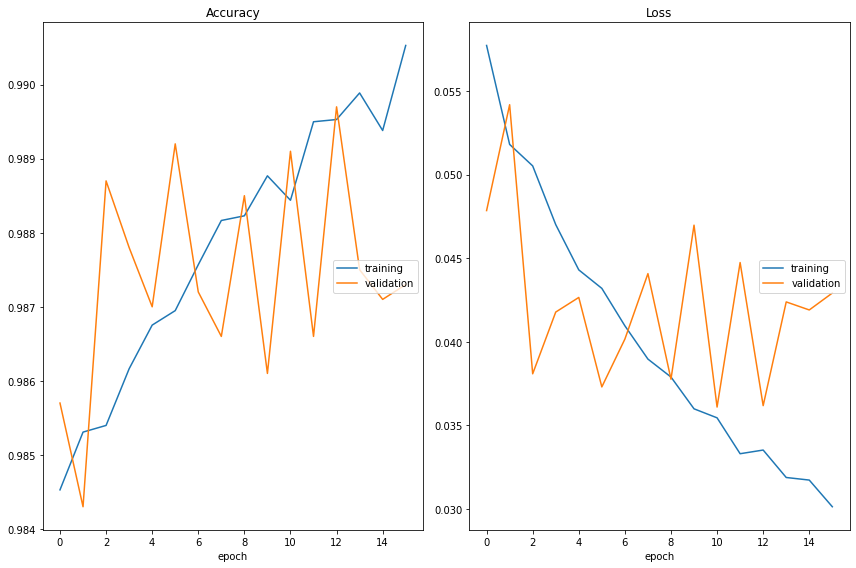

Accuracy
	training         	 (min:    0.985, max:    0.991, cur:    0.991)
	validation       	 (min:    0.984, max:    0.990, cur:    0.987)
Loss
	training         	 (min:    0.030, max:    0.058, cur:    0.030)
	validation       	 (min:    0.036, max:    0.054, cur:    0.043)

Epoch 00016: val_acc did not improve from 0.98970
391/391 [==============================] - 1258s 3s/step - loss: 0.0301 - acc: 0.9905 - val_loss: 0.0429 - val_acc: 0.9873
Epoch 17/20
298/391 [=====================>........] - ETA: 4:38 - loss: 0.0295 - acc: 0.9905

In [ ]:
EPOCHS=20 
STEPS_PER_EPOCH = np.round(len(df)/BATCH_SIZE)

history_second_tune = model_loading_check.fit_generator(
    train_data_gen_aug,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback(), checkpoint_second_tune]) 

# 7. Строим ROC кривую

### Загружаем лучшую модель

In [ ]:
model_loading_check = load_model(cpt_path_second_tune)
loss, acc = model_loading_check.evaluate(val_data_gen)
loss, acc

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
40/40 [==============================] - 31s 766ms/step - loss: 0.0365 - acc: 0.9897


(0.03651082426076755, 0.9897)

In [ ]:
preds = model_loading_check.predict(val_data_gen)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(df_valid['label'].map({'female': 0, 'male': 1}).values, preds);
auc = roc_auc_score(df_valid['label'].map({'female': 0, 'male': 1}).values, preds);

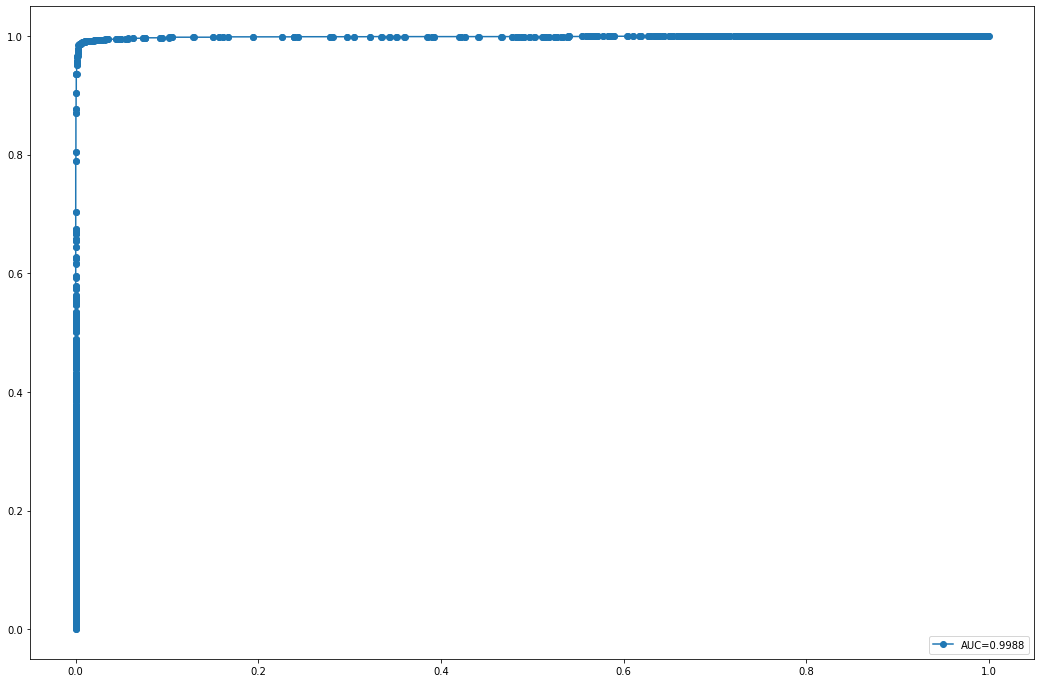

In [ ]:
plt.figure(figsize=(18,12))
plt.plot(fpr, tpr, label="AUC=" + str(np.round(auc, 4)), marker = 'o');
plt.legend(loc=4);

In [ ]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

Threshold value is: 0.31191915


In [ ]:
df_valid['preds'] = preds
df_valid['preds'] = df_valid['preds'].apply(lambda x: x>optimal_threshold).map({True: 'male', False: 'female'})
df_valid

,file_name,label,preds
11395,internship_data/female/156346.jpg,female,female
48681,internship_data/male/141188.jpg,male,male
15472,internship_data/female/199723.jpg,female,female
38496,internship_data/female/200988.jpg,female,female
33701,internship_data/male/027392.jpg,male,male
...,...,...,...
8835,internship_data/female/156283.jpg,female,female
3178,internship_data/female/067811.jpg,female,female
32309,internship_data/female/032810.jpg,female,female
41771,internship_data/male/113351.jpg,male,male


In [ ]:
misstakes = df_valid[df_valid['label']!=df_valid['preds']]
misstakes

,file_name,label,preds
17871,internship_data/female/006838.jpg,female,male
40221,internship_data/male/148131.jpg,male,female
28016,internship_data/male/139191.jpg,male,female
43600,internship_data/male/056760.jpg,male,female
27126,internship_data/male/126764.jpg,male,female
...,...,...,...
25956,internship_data/female/028680.jpg,female,male
23766,internship_data/male/183267.jpg,male,female
1649,internship_data/male/183995.jpg,male,female
10980,internship_data/female/192648.jpg,female,male


### Посмотрим ошибки

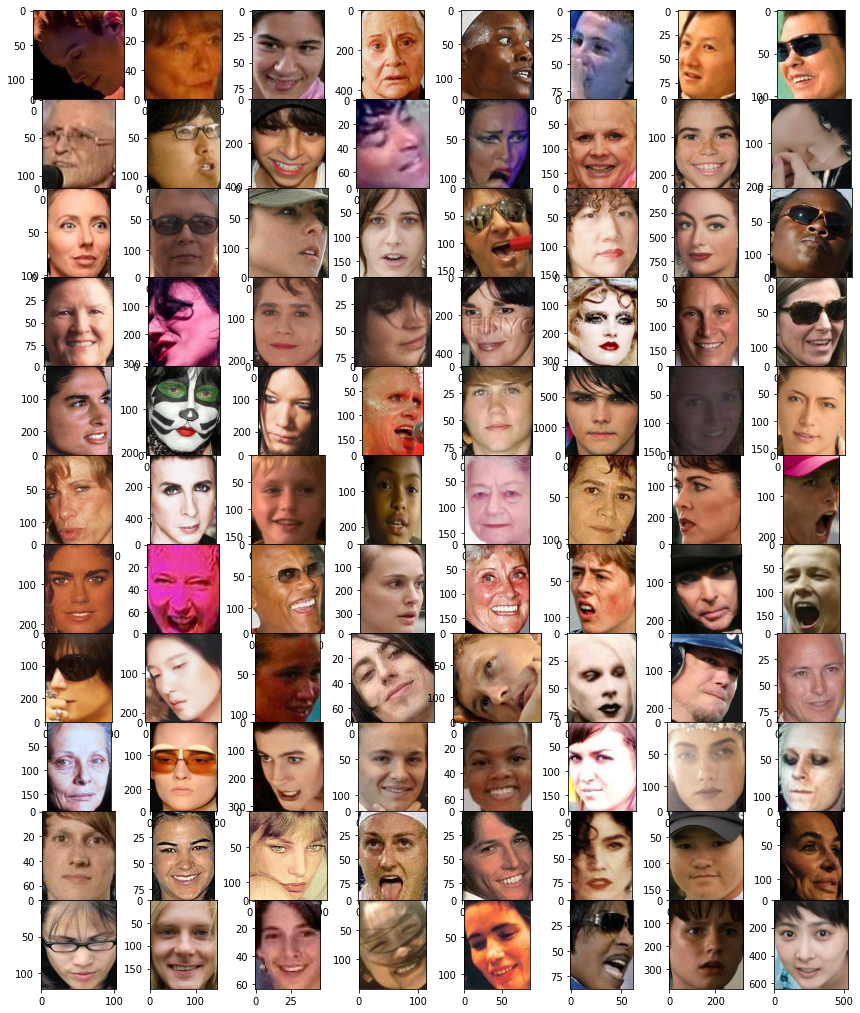

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15, 18))
columns = 8
rows = 11
for i in range(1, columns*rows +1):
    row = misstakes.iloc[i-1]
    img = plt.imread(str(row["file_name"]))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()